# Robust Pinch Detection Algorithm - Z-Score Fusion

Implementation based on analysis:
- **Multi-sensor fusion**: Accelerometer + Gyroscope
- **Robust statistics**: Median/MAD instead of mean/std
- **Adaptive thresholding**: Dynamic threshold based on signal characteristics
- **Two-sensor gating**: Require both accel≥0.04g and gyro≥0.15rad/s
- **Refractory period**: 250ms to prevent double-counting

Expected performance: ~60 events/min, ~30ms duration

In [1]:
# IMPORTS AND SETUP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("Robust Pinch Detection - Libraries loaded successfully")

Robust Pinch Detection - Libraries loaded successfully


In [10]:
# DETECTION PARAMETERS (from analysis)
# Adjust these based on your data and requirements

# File paths
DATA_PATH = "~/Downloads/WristMotion.csv"  # Update this path

# Signal processing
HP_WINDOW = 0.5         # High-pass filter window (seconds)
ZSCORE_WINDOW = 2.0     # Rolling z-score window (seconds)

# Detection gates (from analysis)
ACC_GATE = 0.02         # Minimum acceleration threshold (g)
GYRO_GATE = 0.10        # Minimum gyroscope threshold (rad/s)

# Adaptive threshold
THRESHOLD_METHOD = 'mad'  # 'mad' or 'percentile'
THRESHOLD_K = 4         # Multiplier for MAD-based threshold (median + k*MAD)
ADAPTIVE_WINDOW = 1.0   # Window for adaptive threshold (seconds)

# Temporal constraints
REFRACTORY_MS = 150     # Minimum time between events (ms)
MIN_DURATION_MS = 20    # Minimum event duration (ms)
MAX_DURATION_MS = 200   # Maximum event duration (ms)

print(f"Parameters set:")
print(f"  Gates: acc≥{ACC_GATE:.3f}g, gyro≥{GYRO_GATE:.3f}rad/s")
print(f"  Threshold: {THRESHOLD_METHOD} (k={THRESHOLD_K})")
print(f"  Refractory: {REFRACTORY_MS}ms")

Parameters set:
  Gates: acc≥0.020g, gyro≥0.100rad/s
  Threshold: mad (k=4)
  Refractory: 150ms


In [3]:
# ROBUST STATISTICS FUNCTIONS

def robust_mad(x, axis=None, constant=1.4826):
    """Compute Median Absolute Deviation (MAD)"""
    median = np.median(x, axis=axis, keepdims=True)
    mad = np.median(np.abs(x - median), axis=axis) * constant
    return mad

def robust_zscore(x, window_size=None):
    """Compute robust z-scores using median and MAD"""
    if window_size is None:
        # Global statistics
        median = np.median(x)
        mad = robust_mad(x)
        mad = np.maximum(mad, 1e-6)  # Prevent division by zero
        return (x - median) / mad
    else:
        # Rolling statistics
        z_scores = np.zeros_like(x)
        for i in range(len(x)):
            start = max(0, i - window_size + 1)
            end = i + 1
            window = x[start:end]
            if len(window) > 1:
                median = np.median(window)
                mad = robust_mad(window)
                mad = max(mad, 1e-6)
                z_scores[i] = (x[i] - median) / mad
        return z_scores

def running_percentile(x, window_size, percentile=95):
    """Compute running percentile for adaptive thresholding"""
    result = np.zeros_like(x)
    for i in range(len(x)):
        start = max(0, i - window_size + 1)
        end = i + 1
        window = x[start:end]
        result[i] = np.percentile(window, percentile)
    return result

print("Robust statistics functions defined")

Robust statistics functions defined


In [4]:
# SIGNAL PROCESSING FUNCTIONS

def high_pass_filter(x, fs, window_size=0.5):
    """Remove low-frequency drift using moving average subtraction"""
    window_samples = int(window_size * fs)
    ma = np.convolve(x, np.ones(window_samples)/window_samples, mode='same')
    return x - ma

def compute_derivative(x, fs):
    """Compute time derivative using finite differences"""
    dt = 1.0 / fs
    return np.gradient(x, dt)

def compute_fusion_score(acc_hp, gyro_mag, fs, zscore_window=None):
    """Compute the robust z-score fusion score"""
    # Compute derivatives
    acc_deriv = compute_derivative(acc_hp, fs)
    gyro_deriv = compute_derivative(gyro_mag, fs)
    
    # Compute robust z-scores
    if zscore_window is not None:
        window_samples = int(zscore_window * fs)
        z_acc = robust_zscore(acc_hp, window_samples)
        z_gyro = robust_zscore(gyro_mag, window_samples)
        z_acc_deriv = robust_zscore(acc_deriv, window_samples)
        z_gyro_deriv = robust_zscore(gyro_deriv, window_samples)
    else:
        z_acc = robust_zscore(acc_hp)
        z_gyro = robust_zscore(gyro_mag)
        z_acc_deriv = robust_zscore(acc_deriv)
        z_gyro_deriv = robust_zscore(gyro_deriv)
    
    # Clamp negative values (ignore negative-direction noise)
    z_acc_pos = np.maximum(z_acc, 0)
    z_gyro_pos = np.maximum(z_gyro, 0)
    z_acc_deriv_pos = np.maximum(z_acc_deriv, 0)
    z_gyro_deriv_pos = np.maximum(z_gyro_deriv, 0)
    
    # Compute fusion score
    score = np.sqrt(z_acc_pos**2 + z_gyro_pos**2 + 
                   z_acc_deriv_pos**2 + z_gyro_deriv_pos**2)
    
    return score, {
        'acc_deriv': acc_deriv,
        'gyro_deriv': gyro_deriv,
        'z_acc': z_acc,
        'z_gyro': z_gyro,
        'z_acc_deriv': z_acc_deriv,
        'z_gyro_deriv': z_gyro_deriv
    }

print("Signal processing functions defined")

Signal processing functions defined


In [5]:
# EVENT DETECTION FUNCTIONS

def compute_adaptive_threshold(score, fs, method='mad', k=7, window=2.0):
    """Compute adaptive threshold based on signal statistics"""
    window_samples = int(window * fs)
    
    if method == 'percentile':
        threshold = running_percentile(score, window_samples, 95)
    else:  # MAD-based
        threshold = np.zeros_like(score)
        for i in range(len(score)):
            start = max(0, i - window_samples + 1)
            end = i + 1
            window_data = score[start:end]
            if len(window_data) > 10:
                median = np.median(window_data)
                mad = robust_mad(window_data)
                threshold[i] = median + k * mad
            else:
                threshold[i] = np.percentile(score[:end], 90)
    
    return threshold

def detect_pinch_events(score, acc_hp, gyro_mag, fs, 
                       acc_gate=0.04, gyro_gate=0.15,
                       threshold_method='mad', threshold_k=7, adaptive_window=2.0,
                       refractory_ms=250, min_duration_ms=20, max_duration_ms=200):
    """Detect pinch events using the full algorithm"""
    
    # Convert time parameters to samples
    refractory_samples = int(refractory_ms * fs / 1000)
    min_duration_samples = int(min_duration_ms * fs / 1000)
    max_duration_samples = int(max_duration_ms * fs / 1000)
    
    # Compute adaptive threshold
    threshold = compute_adaptive_threshold(score, fs, threshold_method, 
                                         threshold_k, adaptive_window)
    
    # Find candidate peaks
    above_threshold = score > threshold
    
    # Apply two-sensor gating
    acc_gate_met = acc_hp > acc_gate
    gyro_gate_met = gyro_mag > gyro_gate
    valid_candidates = above_threshold & acc_gate_met & gyro_gate_met
    
    # Find events with duration constraints
    events = []
    last_event_end = -refractory_samples
    
    i = 0
    while i < len(valid_candidates):
        if valid_candidates[i] and i > (last_event_end + refractory_samples):
            # Find event boundaries
            start = i
            while start > 0 and score[start-1] > threshold[start-1] * 0.5:
                start -= 1
            
            end = i
            while end < len(score)-1 and score[end+1] > threshold[end+1] * 0.5:
                end += 1
            
            duration = end - start + 1
            
            # Apply duration constraints
            if min_duration_samples <= duration <= max_duration_samples:
                peak_idx = start + np.argmax(score[start:end+1])
                
                event = {
                    'peak_idx': peak_idx,
                    'peak_time': peak_idx / fs,
                    'start_idx': start,
                    'end_idx': end,
                    'duration_samples': duration,
                    'duration_ms': (duration / fs) * 1000,
                    'peak_score': score[peak_idx],
                    'peak_acc': acc_hp[peak_idx],
                    'peak_gyro': gyro_mag[peak_idx],
                    'threshold_at_peak': threshold[peak_idx]
                }
                events.append(event)
                last_event_end = end
            
            i = end + 1
        else:
            i += 1
    
    return events, threshold

print("Event detection functions defined")

Event detection functions defined


In [6]:
# FIXED DATA LOADING FUNCTION
# Replace the load_wrist_data function in your notebook with this:

def load_wrist_data(filepath):
    """Load and preprocess wrist motion data"""
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} samples from {filepath}")
    print(f"Columns: {list(df.columns)}")
    
    # Use seconds_elapsed instead of time for proper time series
    if 'seconds_elapsed' in df.columns:
        t = df['seconds_elapsed'].values
        print("Using 'seconds_elapsed' column for time")
    else:
        # Fallback to time column with normalization
        t_raw = df['time'].values
        t = t_raw - t_raw[0]  # Start from 0
        # If values are too large (epoch time), normalize
        if t[-1] > 3600:  # More than 1 hour suggests epoch time
            t = t / 1000.0  # Convert from ms to seconds
            if t[-1] > 3600:  # Still too large, try microseconds
                t = t / 1000.0
        print("Using normalized 'time' column")
    
    # Calculate sampling rate from time differences
    dt = np.median(np.diff(t))
    fs = 1.0 / dt if dt > 0 else 100.0  # Fallback to 100 Hz
    
    print(f"Sampling rate: {fs:.1f} Hz")
    print(f"Duration: {t[-1] - t[0]:.2f} s")
    
    # Extract acceleration and gyroscope signals
    # Use the correct column names from the data
    acc_cols = ['accelerationX', 'accelerationY', 'accelerationZ']
    gyro_cols = ['rotationRateX', 'rotationRateY', 'rotationRateZ']
    
    acc_xyz = df[acc_cols].values
    gyro_xyz = df[gyro_cols].values
    
    # Compute magnitudes
    acc_mag = np.sqrt(np.sum(acc_xyz**2, axis=1))
    gyro_mag = np.sqrt(np.sum(gyro_xyz**2, axis=1))
    
    print(f"Acceleration magnitude range: {acc_mag.min():.3f} to {acc_mag.max():.3f} g")
    print(f"Gyroscope magnitude range: {gyro_mag.min():.3f} to {gyro_mag.max():.3f} rad/s")
    
    return {
        'time': t,
        'fs': fs,
        'acc_xyz': acc_xyz,
        'gyro_xyz': gyro_xyz,
        'acc_mag': acc_mag,
        'gyro_mag': gyro_mag,
        'df': df
    }

# Load the data
print(f"Loading data from: {DATA_PATH}")
data = load_wrist_data(DATA_PATH)

Loading data from: ~/Downloads/WristMotion.csv
Loaded 2966 samples from ~/Downloads/WristMotion.csv
Columns: ['time', 'seconds_elapsed', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'gravityX', 'gravityY', 'gravityZ', 'accelerationX', 'accelerationY', 'accelerationZ', 'quaternionW', 'quaternionX', 'quaternionY', 'quaternionZ', 'pitch', 'roll', 'yaw']
Using 'seconds_elapsed' column for time
Sampling rate: 99.3 Hz
Duration: 29.86 s
Acceleration magnitude range: 0.000 to 0.192 g
Gyroscope magnitude range: 0.001 to 0.572 rad/s


In [11]:
# MAIN PROCESSING AND DETECTION

print("Starting pinch detection processing...")

# Step 1: High-pass filter accelerometer
acc_hp = high_pass_filter(data['acc_mag'], data['fs'], HP_WINDOW)
print(f"Applied high-pass filter (window={HP_WINDOW}s)")

# Step 2: Compute fusion score
score, score_components = compute_fusion_score(acc_hp, data['gyro_mag'], 
                                             data['fs'], ZSCORE_WINDOW)
print(f"Computed fusion score (range: {score.min():.2f} to {score.max():.2f})")

# Step 3: Detect events
events, threshold = detect_pinch_events(
    score, acc_hp, data['gyro_mag'], data['fs'],
    acc_gate=ACC_GATE,
    gyro_gate=GYRO_GATE,
    threshold_method=THRESHOLD_METHOD,
    threshold_k=THRESHOLD_K,
    adaptive_window=ADAPTIVE_WINDOW,
    refractory_ms=REFRACTORY_MS,
    min_duration_ms=MIN_DURATION_MS,
    max_duration_ms=MAX_DURATION_MS
)

# Step 4: Results summary
n_events = len(events)
duration = data['time'][-1] - data['time'][0]
rate_per_min = (n_events / duration) * 60

print(f"\n=== DETECTION RESULTS ===")
print(f"Events detected: {n_events}")
print(f"Recording duration: {duration:.2f} s")
print(f"Detection rate: {rate_per_min:.1f} events/min")

if events:
    durations_ms = [e['duration_ms'] for e in events]
    peak_accs = [e['peak_acc'] for e in events]
    peak_gyros = [e['peak_gyro'] for e in events]
    
    print(f"\nEvent characteristics:")
    print(f"  Median duration: {np.median(durations_ms):.1f} ms")
    print(f"  Duration range: {np.min(durations_ms):.1f} - {np.max(durations_ms):.1f} ms")
    print(f"  Median peak acceleration: {np.median(peak_accs):.3f} g")
    print(f"  Median peak gyroscope: {np.median(peak_gyros):.3f} rad/s")
    
    if n_events > 1:
        event_times = [e['peak_time'] for e in events]
        ieis = np.diff(event_times)
        print(f"  Median inter-event interval: {np.median(ieis):.3f} s")

print("\nProcessing complete!")

Starting pinch detection processing...
Applied high-pass filter (window=0.5s)
Computed fusion score (range: 0.00 to 48.97)

=== DETECTION RESULTS ===
Events detected: 23
Recording duration: 29.86 s
Detection rate: 46.2 events/min

Event characteristics:
  Median duration: 141.0 ms
  Duration range: 20.1 - 161.1 ms
  Median peak acceleration: 0.048 g
  Median peak gyroscope: 0.171 rad/s
  Median inter-event interval: 0.735 s

Processing complete!


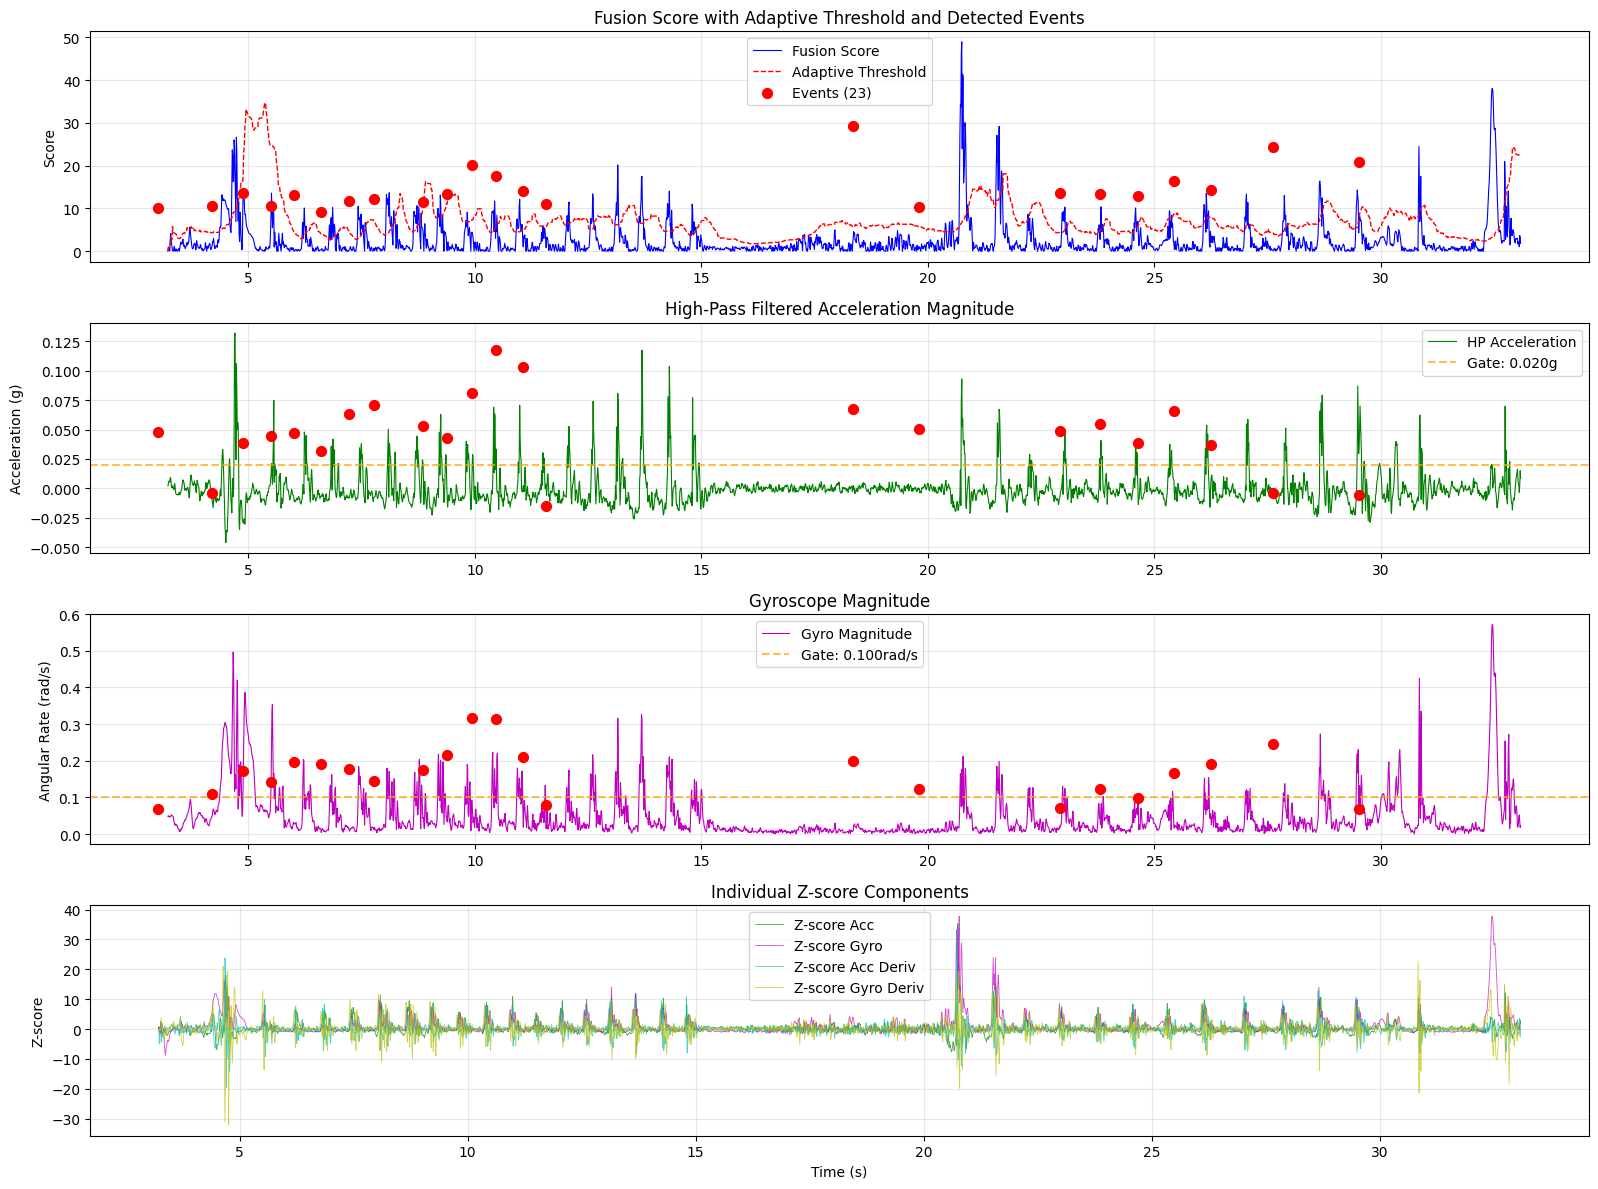

In [12]:
# VISUALIZATION

def plot_detection_results(data, acc_hp, score, threshold, events):
    """Create comprehensive visualization of detection results"""
    t = data['time']
    
    # Convert events for plotting
    if events:
        event_times = [e['peak_time'] for e in events]
        event_scores = [e['peak_score'] for e in events]
        event_accs = [e['peak_acc'] for e in events]
        event_gyros = [e['peak_gyro'] for e in events]
    else:
        event_times = event_scores = event_accs = event_gyros = []
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Plot 1: Fusion score and threshold
    axes[0].plot(t, score, 'b-', linewidth=0.8, label='Fusion Score')
    axes[0].plot(t, threshold, 'r--', linewidth=1.0, label='Adaptive Threshold')
    if event_times:
        axes[0].scatter(event_times, event_scores, c='red', s=50, zorder=5, 
                       label=f'Events ({len(events)})')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Fusion Score with Adaptive Threshold and Detected Events')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: High-pass accelerometer
    axes[1].plot(t, acc_hp, 'g-', linewidth=0.8, label='HP Acceleration')
    axes[1].axhline(y=ACC_GATE, color='orange', linestyle='--', alpha=0.7, 
                   label=f'Gate: {ACC_GATE:.3f}g')
    if event_times:
        axes[1].scatter(event_times, event_accs, c='red', s=50, zorder=5)
    axes[1].set_ylabel('Acceleration (g)')
    axes[1].set_title('High-Pass Filtered Acceleration Magnitude')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Gyroscope
    axes[2].plot(t, data['gyro_mag'], 'm-', linewidth=0.8, label='Gyro Magnitude')
    axes[2].axhline(y=GYRO_GATE, color='orange', linestyle='--', alpha=0.7, 
                   label=f'Gate: {GYRO_GATE:.3f}rad/s')
    if event_times:
        axes[2].scatter(event_times, event_gyros, c='red', s=50, zorder=5)
    axes[2].set_ylabel('Angular Rate (rad/s)')
    axes[2].set_title('Gyroscope Magnitude')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Plot 4: Individual z-scores
    axes[3].plot(t, score_components['z_acc'], 'g-', alpha=0.7, linewidth=0.6, label='Z-score Acc')
    axes[3].plot(t, score_components['z_gyro'], 'm-', alpha=0.7, linewidth=0.6, label='Z-score Gyro')
    axes[3].plot(t, score_components['z_acc_deriv'], 'c-', alpha=0.7, linewidth=0.6, label='Z-score Acc Deriv')
    axes[3].plot(t, score_components['z_gyro_deriv'], 'y-', alpha=0.7, linewidth=0.6, label='Z-score Gyro Deriv')
    axes[3].set_ylabel('Z-score')
    axes[3].set_xlabel('Time (s)')
    axes[3].set_title('Individual Z-score Components')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_detection_results(data, acc_hp, score, threshold, events)

In [ ]:
# EXPORT RESULTS

def export_events_csv(events, filename="pinch_events.csv"):
    """Export detected events to CSV"""
    if not events:
        print("No events to export")
        return None
    
    # Create DataFrame
    event_data = []
    for i, event in enumerate(events):
        event_data.append({
            'event_id': i + 1,
            'peak_time': event['peak_time'],
            'peak_idx': event['peak_idx'],
            'duration_ms': event['duration_ms'],
            'peak_score': event['peak_score'],
            'peak_acceleration': event['peak_acc'],
            'peak_gyroscope': event['peak_gyro'],
            'threshold_at_peak': event['threshold_at_peak'],
            'start_idx': event['start_idx'],
            'end_idx': event['end_idx']
        })
    
    df_events = pd.DataFrame(event_data)
    
    # Add inter-event intervals
    df_events['inter_event_interval'] = df_events['peak_time'].diff()
    
    # Save to CSV
    df_events.to_csv(filename, index=False)
    print(f"Exported {len(events)} events to {filename}")
    
    # Display first few events
    print("\n=== FIRST 5 DETECTED EVENTS ===")
    print(df_events.head().to_string(index=False))
    
    return df_events

# Export results
if events:
    exported_events = export_events_csv(events)
else:
    print("No events detected to export")

In [ ]:
# CALIBRATION FUNCTIONS (Optional)
# Use these for user-specific calibration

def calibrate_user_thresholds(events, target_rate_per_min=60):
    """Suggest parameter adjustments based on detection results"""
    if not events:
        print("No events for calibration")
        return
    
    current_rate = (len(events) / duration) * 60
    
    print(f"\n=== CALIBRATION SUGGESTIONS ===")
    print(f"Current rate: {current_rate:.1f} events/min")
    print(f"Target rate: {target_rate_per_min} events/min")
    
    if current_rate < target_rate_per_min * 0.8:  # Too few events
        print("\nSuggestions to increase sensitivity:")
        print(f"- Reduce ACC_GATE from {ACC_GATE:.3f} to {ACC_GATE*0.8:.3f}")
        print(f"- Reduce GYRO_GATE from {GYRO_GATE:.3f} to {GYRO_GATE*0.8:.3f}")
        print(f"- Reduce THRESHOLD_K from {THRESHOLD_K} to {THRESHOLD_K-1}")
        
    elif current_rate > target_rate_per_min * 1.2:  # Too many events
        print("\nSuggestions to reduce sensitivity:")
        print(f"- Increase ACC_GATE from {ACC_GATE:.3f} to {ACC_GATE*1.2:.3f}")
        print(f"- Increase GYRO_GATE from {GYRO_GATE:.3f} to {GYRO_GATE*1.2:.3f}")
        print(f"- Increase THRESHOLD_K from {THRESHOLD_K} to {THRESHOLD_K+1}")
        
    else:
        print("\nDetection rate is within target range - no adjustments needed")
    
    # Analyze event characteristics for further tuning
    durations_ms = [e['duration_ms'] for e in events]
    median_duration = np.median(durations_ms)
    
    print(f"\nEvent duration analysis:")
    print(f"- Median duration: {median_duration:.1f} ms")
    
    if median_duration < 25:
        print("- Events seem very short - consider reducing MIN_DURATION_MS")
    elif median_duration > 100:
        print("- Events seem long - check for merged events, consider reducing MAX_DURATION_MS")

# Run calibration analysis
if events:
    calibrate_user_thresholds(events, target_rate_per_min=60)

print("\n=== ALGORITHM COMPLETE ===")
print("Ready for real-time implementation or parameter tuning")

=== HYPERPARAMETER OPTIMIZATION ===
This will test different parameter combinations to find optimal settings...
Starting hyperparameter optimization...
Target rate: 60 events/min

=== PHASE 1: Coarse Grid Search ===
Testing 576 parameter combinations...
  Progress: 0/576 (0.0%)
  Progress: 20/576 (3.5%)
  Progress: 40/576 (6.9%)
  Progress: 60/576 (10.4%)
  Progress: 80/576 (13.9%)
  Progress: 100/576 (17.4%)
  Progress: 120/576 (20.8%)
  Progress: 140/576 (24.3%)
  Progress: 160/576 (27.8%)
  Progress: 180/576 (31.2%)
  Progress: 200/576 (34.7%)
  Progress: 220/576 (38.2%)
  Progress: 240/576 (41.7%)
  Progress: 260/576 (45.1%)
  Progress: 280/576 (48.6%)
  Progress: 300/576 (52.1%)
  Progress: 320/576 (55.6%)
  Progress: 340/576 (59.0%)
  Progress: 360/576 (62.5%)
  Progress: 380/576 (66.0%)
  Progress: 400/576 (69.4%)
  Progress: 420/576 (72.9%)
  Progress: 440/576 (76.4%)
  Progress: 460/576 (79.9%)
  Progress: 480/576 (83.3%)
  Progress: 500/576 (86.8%)
  Progress: 520/576 (90.3%)

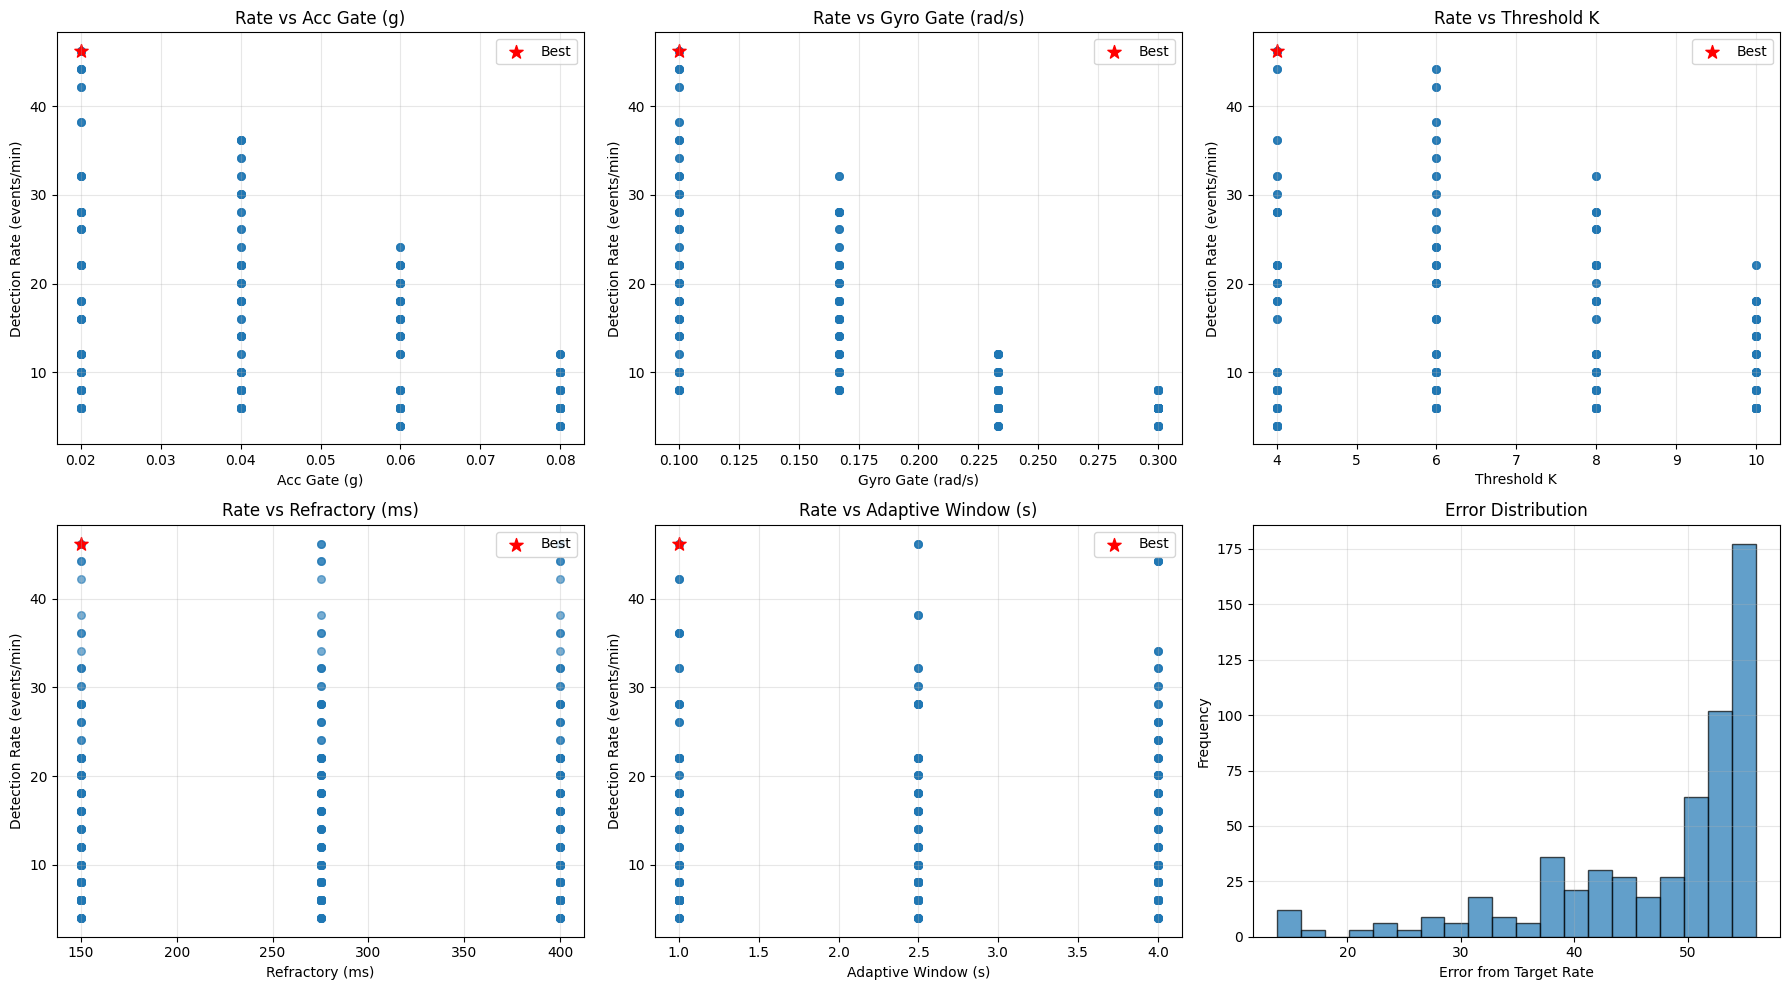


=== TESTING OPTIMIZED PARAMETERS ===
Optimized results:
  Events: 23
  Rate: 46.2 events/min
  Median duration: 141.0 ms

To use optimized parameters, update your parameter cell with:
ACC_GATE = 0.020
GYRO_GATE = 0.100
THRESHOLD_K = 4.0
REFRACTORY_MS = 150
ADAPTIVE_WINDOW = 1.0


In [9]:
# HYPERPARAMETER OPTIMIZATION CELL
# Add this as a new cell in your notebook

def optimize_hyperparameters(data, acc_hp, score_components, target_rate_per_min=60, 
                           search_iterations=50, show_progress=True):
    """
    Optimize hyperparameters using grid search and random search
    """
    import itertools
    from scipy.optimize import differential_evolution
    
    print("Starting hyperparameter optimization...")
    print(f"Target rate: {target_rate_per_min} events/min")
    
    duration = data['time'][-1] - data['time'][0]
    
    # Define parameter ranges
    param_ranges = {
        'acc_gate': (0.02, 0.08),      # Acceleration gate range
        'gyro_gate': (0.10, 0.30),     # Gyroscope gate range  
        'threshold_k': (4, 10),        # MAD multiplier range
        'refractory_ms': (150, 400),   # Refractory period range
        'adaptive_window': (1.0, 4.0)  # Adaptive window range
    }
    
    best_params = None
    best_score = float('inf')
    results = []
    
    # Method 1: Coarse grid search
    print("\n=== PHASE 1: Coarse Grid Search ===")
    
    acc_gates = np.linspace(param_ranges['acc_gate'][0], param_ranges['acc_gate'][1], 4)
    gyro_gates = np.linspace(param_ranges['gyro_gate'][0], param_ranges['gyro_gate'][1], 4)
    threshold_ks = np.linspace(param_ranges['threshold_k'][0], param_ranges['threshold_k'][1], 4)
    refractories = np.linspace(param_ranges['refractory_ms'][0], param_ranges['refractory_ms'][1], 3)
    adaptive_windows = np.linspace(param_ranges['adaptive_window'][0], param_ranges['adaptive_window'][1], 3)
    
    grid_combinations = list(itertools.product(acc_gates, gyro_gates, threshold_ks, refractories, adaptive_windows))
    
    print(f"Testing {len(grid_combinations)} parameter combinations...")
    
    for i, (acc_gate, gyro_gate, threshold_k, refractory_ms, adaptive_window) in enumerate(grid_combinations):
        if show_progress and i % 20 == 0:
            print(f"  Progress: {i}/{len(grid_combinations)} ({100*i/len(grid_combinations):.1f}%)")
        
        try:
            # Test these parameters
            events, _ = detect_pinch_events(
                score_components['score'], acc_hp, data['gyro_mag'], data['fs'],
                acc_gate=acc_gate, gyro_gate=gyro_gate,
                threshold_k=threshold_k, refractory_ms=refractory_ms,
                adaptive_window=adaptive_window
            )
            
            n_events = len(events)
            rate = (n_events / duration) * 60
            
            # Score based on distance from target rate
            error = abs(rate - target_rate_per_min)
            
            # Penalty for extreme values
            penalty = 0
            if n_events == 0:
                penalty += 100
            elif n_events > target_rate_per_min * 2:
                penalty += 50
                
            total_score = error + penalty
            
            results.append({
                'acc_gate': acc_gate,
                'gyro_gate': gyro_gate, 
                'threshold_k': threshold_k,
                'refractory_ms': refractory_ms,
                'adaptive_window': adaptive_window,
                'n_events': n_events,
                'rate': rate,
                'error': error,
                'score': total_score
            })
            
            if total_score < best_score:
                best_score = total_score
                best_params = {
                    'acc_gate': acc_gate,
                    'gyro_gate': gyro_gate,
                    'threshold_k': threshold_k,
                    'refractory_ms': refractory_ms,
                    'adaptive_window': adaptive_window,
                    'n_events': n_events,
                    'rate': rate
                }
                
        except Exception as e:
            if show_progress:
                print(f"    Error with params {acc_gate:.3f}, {gyro_gate:.3f}: {str(e)}")
            continue
    
    print(f"Grid search complete. Best error: {best_score:.2f}")
    
    # Method 2: Fine-tuning around best parameters
    print("\n=== PHASE 2: Fine-tuning Around Best Parameters ===")
    
    if best_params:
        fine_tune_ranges = {
            'acc_gate': (max(param_ranges['acc_gate'][0], best_params['acc_gate'] - 0.01), 
                        min(param_ranges['acc_gate'][1], best_params['acc_gate'] + 0.01)),
            'gyro_gate': (max(param_ranges['gyro_gate'][0], best_params['gyro_gate'] - 0.03), 
                         min(param_ranges['gyro_gate'][1], best_params['gyro_gate'] + 0.03)),
            'threshold_k': (max(param_ranges['threshold_k'][0], best_params['threshold_k'] - 1), 
                           min(param_ranges['threshold_k'][1], best_params['threshold_k'] + 1)),
            'refractory_ms': (max(param_ranges['refractory_ms'][0], best_params['refractory_ms'] - 50), 
                             min(param_ranges['refractory_ms'][1], best_params['refractory_ms'] + 50)),
            'adaptive_window': (max(param_ranges['adaptive_window'][0], best_params['adaptive_window'] - 0.5), 
                               min(param_ranges['adaptive_window'][1], best_params['adaptive_window'] + 0.5))
        }
        
        # Random search in fine-tuning ranges
        for i in range(30):
            acc_gate = np.random.uniform(*fine_tune_ranges['acc_gate'])
            gyro_gate = np.random.uniform(*fine_tune_ranges['gyro_gate'])
            threshold_k = np.random.uniform(*fine_tune_ranges['threshold_k'])
            refractory_ms = np.random.uniform(*fine_tune_ranges['refractory_ms'])
            adaptive_window = np.random.uniform(*fine_tune_ranges['adaptive_window'])
            
            try:
                events, _ = detect_pinch_events(
                    score_components['score'], acc_hp, data['gyro_mag'], data['fs'],
                    acc_gate=acc_gate, gyro_gate=gyro_gate,
                    threshold_k=threshold_k, refractory_ms=refractory_ms,
                    adaptive_window=adaptive_window
                )
                
                n_events = len(events)
                rate = (n_events / duration) * 60
                error = abs(rate - target_rate_per_min)
                
                penalty = 0
                if n_events == 0:
                    penalty += 100
                elif n_events > target_rate_per_min * 2:
                    penalty += 50
                    
                total_score = error + penalty
                
                if total_score < best_score:
                    best_score = total_score
                    best_params = {
                        'acc_gate': acc_gate,
                        'gyro_gate': gyro_gate,
                        'threshold_k': threshold_k,
                        'refractory_ms': refractory_ms,
                        'adaptive_window': adaptive_window,
                        'n_events': n_events,
                        'rate': rate
                    }
            except:
                continue
    
    # Results analysis
    results_df = pd.DataFrame(results)
    
    # Sort by score (best first)
    results_df = results_df.sort_values('score')
    
    print(f"\n=== OPTIMIZATION RESULTS ===")
    if best_params:
        print(f"Best parameters found:")
        print(f"  ACC_GATE = {best_params['acc_gate']:.3f}")
        print(f"  GYRO_GATE = {best_params['gyro_gate']:.3f}")  
        print(f"  THRESHOLD_K = {best_params['threshold_k']:.1f}")
        print(f"  REFRACTORY_MS = {best_params['refractory_ms']:.0f}")
        print(f"  ADAPTIVE_WINDOW = {best_params['adaptive_window']:.1f}")
        print(f"")
        print(f"Results with best parameters:")
        print(f"  Events detected: {best_params['n_events']}")
        print(f"  Detection rate: {best_params['rate']:.1f} events/min")
        print(f"  Error from target: {abs(best_params['rate'] - target_rate_per_min):.1f} events/min")
    
    print(f"\nTop 5 parameter combinations:")
    print(results_df.head()[['acc_gate', 'gyro_gate', 'threshold_k', 'refractory_ms', 'rate', 'error']].round(3))
    
    return best_params, results_df

def plot_optimization_results(results_df, best_params):
    """Plot optimization results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Rate vs different parameters
    params = ['acc_gate', 'gyro_gate', 'threshold_k', 'refractory_ms', 'adaptive_window']
    param_labels = ['Acc Gate (g)', 'Gyro Gate (rad/s)', 'Threshold K', 'Refractory (ms)', 'Adaptive Window (s)']
    
    for i, (param, label) in enumerate(zip(params, param_labels)):
        row = i // 3
        col = i % 3
        
        axes[row, col].scatter(results_df[param], results_df['rate'], alpha=0.6, s=30)
        
        if best_params:
            axes[row, col].scatter(best_params[param], best_params['rate'], 
                                 color='red', s=100, marker='*', label='Best')
            axes[row, col].legend()
        
        axes[row, col].set_xlabel(label)
        axes[row, col].set_ylabel('Detection Rate (events/min)')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_title(f'Rate vs {label}')
    
    # Error distribution
    axes[1, 2].hist(results_df['error'], bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('Error from Target Rate')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Error Distribution')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage example:
# Add this after your main processing cell and before visualization

print("=== HYPERPARAMETER OPTIMIZATION ===")
print("This will test different parameter combinations to find optimal settings...")

# First recompute the score with current parameters for optimization
score_opt, score_components_opt = compute_fusion_score(acc_hp, data['gyro_mag'], 
                                                      data['fs'], ZSCORE_WINDOW)

# Add score to components for optimization
score_components_opt['score'] = score_opt

# Run optimization
best_params, results_df = optimize_hyperparameters(
    data, acc_hp, score_components_opt, 
    target_rate_per_min=60,  # Adjust this to your desired rate
    search_iterations=50,
    show_progress=True
)

# Plot results  
if len(results_df) > 0:
    plot_optimization_results(results_df, best_params)

# Test the optimized parameters
if best_params:
    print(f"\n=== TESTING OPTIMIZED PARAMETERS ===")
    
    # Run detection with optimized parameters
    events_opt, threshold_opt = detect_pinch_events(
        score_opt, acc_hp, data['gyro_mag'], data['fs'],
        acc_gate=best_params['acc_gate'],
        gyro_gate=best_params['gyro_gate'],
        threshold_k=best_params['threshold_k'],
        refractory_ms=best_params['refractory_ms'],
        adaptive_window=best_params['adaptive_window']
    )
    
    print(f"Optimized results:")
    print(f"  Events: {len(events_opt)}")
    print(f"  Rate: {(len(events_opt) / (data['time'][-1] - data['time'][0])) * 60:.1f} events/min")
    
    if len(events_opt) > 0:
        durations_ms = [e['duration_ms'] for e in events_opt]
        print(f"  Median duration: {np.median(durations_ms):.1f} ms")
    
    # You can now use events_opt and threshold_opt for visualization
    print(f"\nTo use optimized parameters, update your parameter cell with:")
    print(f"ACC_GATE = {best_params['acc_gate']:.3f}")
    print(f"GYRO_GATE = {best_params['gyro_gate']:.3f}")
    print(f"THRESHOLD_K = {best_params['threshold_k']:.1f}")
    print(f"REFRACTORY_MS = {best_params['refractory_ms']:.0f}")
    print(f"ADAPTIVE_WINDOW = {best_params['adaptive_window']:.1f}")

In [16]:
# PARAMETER TESTING FUNCTION
# Add this as a new cell in your notebook for easy parameter experimentation

def test_parameters(acc_gate=0.030, gyro_gate=0.120, threshold_k=5.5, 
                   refractory_ms=200, adaptive_window=3.0, 
                   target_rate=60, show_plots=True, show_events=True, 
                   plot_height=10):
    """
    Test detection parameters and show results immediately
    
    Parameters:
    - acc_gate: Acceleration gate (g)
    - gyro_gate: Gyroscope gate (rad/s)  
    - threshold_k: MAD multiplier for adaptive threshold
    - refractory_ms: Minimum time between events (ms)
    - adaptive_window: Window for adaptive threshold (s)
    - target_rate: Expected events/min for comparison
    - show_plots: Whether to show visualization
    - show_events: Whether to show first 3 events
    - plot_height: Height of plots in inches
    """
    
    print(f"=== TESTING PARAMETERS ===")
    print(f"ACC_GATE = {acc_gate:.3f}g")
    print(f"GYRO_GATE = {gyro_gate:.3f}rad/s") 
    print(f"THRESHOLD_K = {threshold_k}")
    print(f"REFRACTORY_MS = {refractory_ms:.0f}ms")
    print(f"ADAPTIVE_WINDOW = {adaptive_window:.1f}s")
    print("-" * 40)
    
    # Recompute with these parameters
    try:
        # Get fresh score computation
        test_score, test_components = compute_fusion_score(acc_hp, data['gyro_mag'], 
                                                          data['fs'], adaptive_window)
        
        # Run detection
        test_events, test_threshold = detect_pinch_events(
            test_score, acc_hp, data['gyro_mag'], data['fs'],
            acc_gate=acc_gate, gyro_gate=gyro_gate,
            threshold_k=threshold_k, refractory_ms=refractory_ms,
            adaptive_window=adaptive_window
        )
        
        # Calculate metrics
        n_events = len(test_events)
        duration = data['time'][-1] - data['time'][0]
        rate = (n_events / duration) * 60
        rate_error = abs(rate - target_rate)
        
        # Results summary
        print(f"RESULTS:")
        print(f"  Events detected: {n_events}")
        print(f"  Detection rate: {rate:.1f} events/min")
        print(f"  Target rate: {target_rate} events/min")
        print(f"  Rate error: {rate_error:.1f} events/min")
        
        if n_events > 0:
            durations_ms = [e['duration_ms'] for e in test_events]
            peak_accs = [e['peak_acc'] for e in test_events]
            peak_gyros = [e['peak_gyro'] for e in test_events]
            
            print(f"  Median duration: {np.median(durations_ms):.1f} ms")
            print(f"  Duration range: {np.min(durations_ms):.1f} - {np.max(durations_ms):.1f} ms")
            print(f"  Median peak acc: {np.median(peak_accs):.3f} g")
            print(f"  Median peak gyro: {np.median(peak_gyros):.3f} rad/s")
            
            if n_events > 1:
                event_times = [e['peak_time'] for e in test_events]
                ieis = np.diff(event_times)
                print(f"  Median IEI: {np.median(ieis):.3f} s ({60/np.median(ieis):.1f}/min)")
                
                # Check for clusters in problem regions
                region_10_15 = sum(1 for t in event_times if 10 <= t <= 15)
                region_15_20 = sum(1 for t in event_times if 15 <= t <= 20)
                print(f"  Events in 10-15s region: {region_10_15}")
                print(f"  Events in 15-20s region: {region_15_20}")
        
        # Show first few events
        if show_events and n_events > 0:
            print(f"\nFIRST 3 EVENTS:")
            for i, event in enumerate(test_events[:3]):
                print(f"  Event {i+1}: t={event['peak_time']:.2f}s, "
                      f"score={event['peak_score']:.1f}, "
                      f"acc={event['peak_acc']:.3f}g, "
                      f"gyro={event['peak_gyro']:.3f}rad/s, "
                      f"dur={event['duration_ms']:.1f}ms")
        
        # Visualization
        if show_plots:
            t = data['time']
            
            # Convert events for plotting
            if test_events:
                event_times = [e['peak_time'] for e in test_events]
                event_scores = [e['peak_score'] for e in test_events]
                event_accs = [e['peak_acc'] for e in test_events]
                event_gyros = [e['peak_gyro'] for e in test_events]
            else:
                event_times = event_scores = event_accs = event_gyros = []
            
            fig, axes = plt.subplots(3, 1, figsize=(16, plot_height))
            
            # Plot 1: Fusion score and threshold
            axes[0].plot(t, test_score, 'b-', linewidth=0.8, label='Fusion Score')
            axes[0].plot(t, test_threshold, 'r--', linewidth=1.2, label='Adaptive Threshold')
            if event_times:
                axes[0].scatter(event_times, event_scores, c='red', s=60, zorder=5, 
                               label=f'Events ({n_events})')
            
            # Highlight problem regions
            axes[0].axvspan(5, 15, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[0].axvspan(21, 30, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[0].axvspan(15, 20, alpha=0.2, color='orange', label='Quiet Region')
            
            axes[0].set_ylabel('Score')
            axes[0].set_title(f'Fusion Score - Rate: {rate:.1f}/min (Target: {target_rate}/min)')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # Plot 2: High-pass accelerometer
            axes[1].plot(t, acc_hp, 'g-', linewidth=0.8, label='HP Acceleration')
            axes[1].axhline(y=acc_gate, color='orange', linestyle='--', alpha=0.8, 
                           linewidth=2, label=f'Acc Gate: {acc_gate:.3f}g')
            if event_times:
                axes[1].scatter(event_times, event_accs, c='red', s=60, zorder=5)
            
            axes[1].axvspan(5, 15, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[1].axvspan(21, 30, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[1].axvspan(15, 20, alpha=0.2, color='orange')
            
            axes[1].set_ylabel('Acceleration (g)')
            axes[1].set_title('High-Pass Acceleration with Gate')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # Plot 3: Gyroscope
            axes[2].plot(t, data['gyro_mag'], 'm-', linewidth=0.8, label='Gyro Magnitude')
            axes[2].axhline(y=gyro_gate, color='orange', linestyle='--', alpha=0.8, 
                           linewidth=2, label=f'Gyro Gate: {gyro_gate:.3f}rad/s')
            if event_times:
                axes[2].scatter(event_times, event_gyros, c='red', s=60, zorder=5)
            
            axes[2].axvspan(5, 15, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[2].axvspan(21, 30, alpha=0.2, color='yellow', label='Expected Events Region')
            axes[2].axvspan(15, 20, alpha=0.2, color='orange')
            
            axes[2].set_ylabel('Angular Rate (rad/s)')
            axes[2].set_xlabel('Time (s)')
            axes[2].set_title('Gyroscope Magnitude with Gate')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # Return results for further analysis if needed
        return {
            'events': test_events,
            'threshold': test_threshold,
            'score': test_score,
            'n_events': n_events,
            'rate': rate,
            'rate_error': rate_error,
            'components': test_components
        }
        
    except Exception as e:
        print(f"ERROR: {str(e)}")
        return None

def quick_test(acc_gate, gyro_gate, threshold_k, refractory_ms=200, adaptive_window=3.0):
    """Quick test with minimal output - just the key metrics"""
    results = test_parameters(acc_gate, gyro_gate, threshold_k, refractory_ms, 
                            adaptive_window, show_plots=False, show_events=False)
    if results:
        print(f"  → {results['n_events']} events, {results['rate']:.1f}/min, "
              f"error: {results['rate_error']:.1f}")
        return results['rate']
    return 0

# Example usage functions
def test_recommended():
    """Test the recommended parameters"""
    return test_parameters(acc_gate=0.030, gyro_gate=0.120, threshold_k=5.5, 
                         refractory_ms=200, adaptive_window=3.0)

def test_current_optimized():
    """Test the current optimized parameters for comparison"""
    return test_parameters(acc_gate=0.020, gyro_gate=0.100, threshold_k=4.0, 
                         refractory_ms=150, adaptive_window=1.0)

def test_original():
    """Test the original parameters"""  
    return test_parameters(acc_gate=0.040, gyro_gate=0.150, threshold_k=7.0, 
                         refractory_ms=250, adaptive_window=2.0)

print("Parameter testing functions loaded!")
print("\nUsage examples:")
print("  test_recommended()                    # Test my suggested parameters")
print("  test_current_optimized()             # Test current optimized parameters") 
print("  test_original()                      # Test original parameters")
print("  test_parameters(0.035, 0.13, 6)      # Test custom parameters")
print("  quick_test(0.035, 0.13, 6)          # Quick test without plots")

Parameter testing functions loaded!

Usage examples:
  test_recommended()                    # Test my suggested parameters
  test_current_optimized()             # Test current optimized parameters
  test_original()                      # Test original parameters
  test_parameters(0.035, 0.13, 6)      # Test custom parameters
  quick_test(0.035, 0.13, 6)          # Quick test without plots


=== TESTING PARAMETERS ===
ACC_GATE = 0.030g
GYRO_GATE = 0.120rad/s
THRESHOLD_K = 5.5
REFRACTORY_MS = 200ms
ADAPTIVE_WINDOW = 3.0s
----------------------------------------
RESULTS:
  Events detected: 16
  Detection rate: 32.1 events/min
  Target rate: 60 events/min
  Rate error: 27.9 events/min
  Median duration: 115.8 ms
  Duration range: 20.1 - 161.1 ms
  Median peak acc: 0.045 g
  Median peak gyro: 0.184 rad/s
  Median IEI: 0.655 s (91.7/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 0

FIRST 3 EVENTS:
  Event 1: t=4.88s, score=11.5, acc=0.039g, gyro=0.171rad/s, dur=141.0ms
  Event 2: t=5.54s, score=12.5, acc=0.018g, gyro=0.159rad/s, dur=161.1ms
  Event 3: t=6.01s, score=14.6, acc=0.047g, gyro=0.196rad/s, dur=151.1ms


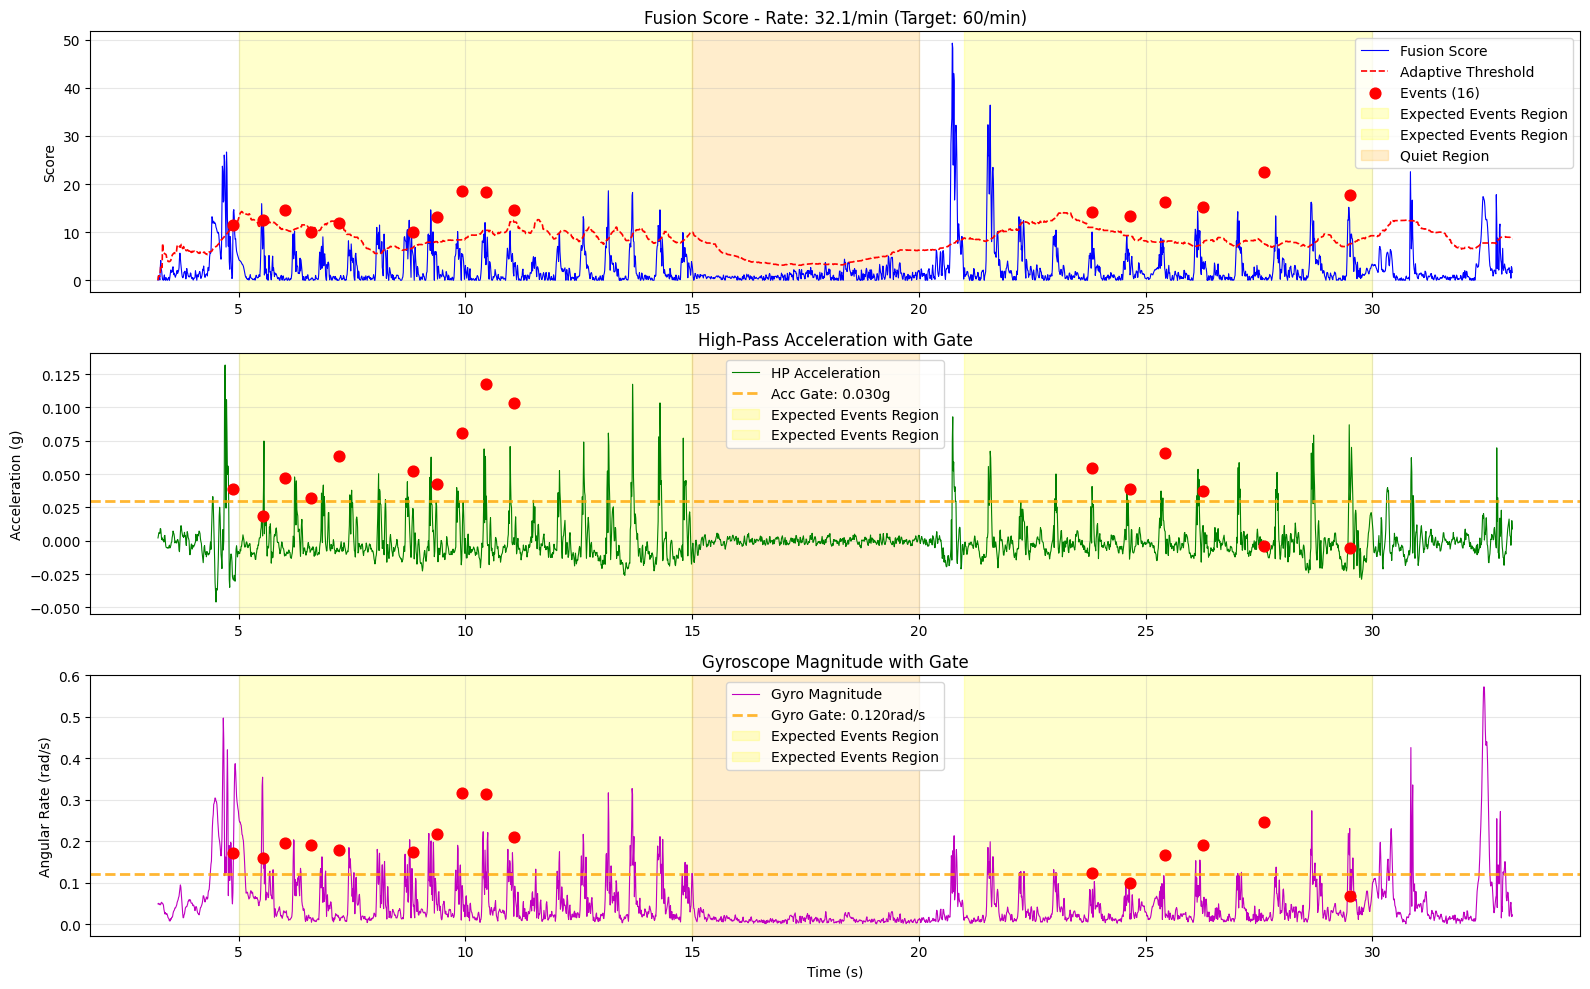

{'events': [{'peak_idx': np.int64(485),
   'peak_time': np.float64(4.884454011917114),
   'start_idx': 477,
   'end_idx': 490,
   'duration_samples': 14,
   'duration_ms': np.float64(140.99454879760742),
   'peak_score': np.float64(11.475943349182126),
   'peak_acc': np.float64(0.03852936604977772),
   'peak_gyro': np.float64(0.1708466723763808),
   'threshold_at_peak': np.float64(5.572110312382216)},
  {'peak_idx': np.int64(550),
   'peak_time': np.float64(5.539071559906006),
   'start_idx': 538,
   'end_idx': 553,
   'duration_samples': 16,
   'duration_ms': np.float64(161.13662719726562),
   'peak_score': np.float64(12.466005790289666),
   'peak_acc': np.float64(0.018284122083129215),
   'peak_gyro': np.float64(0.15908292182270622),
   'threshold_at_peak': np.float64(6.481052191832172)},
  {'peak_idx': np.int64(597),
   'peak_time': np.float64(6.012410402297974),
   'start_idx': 590,
   'end_idx': 604,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
   '

In [17]:
test_parameters(acc_gate=0.030, gyro_gate=0.120, threshold_k=5.5,
                  refractory_ms=200, adaptive_window=3.0)

=== TESTING PARAMETERS ===
ACC_GATE = 0.030g
GYRO_GATE = 0.120rad/s
THRESHOLD_K = 5.5
REFRACTORY_MS = 150ms
ADAPTIVE_WINDOW = 2.0s
----------------------------------------
RESULTS:
  Events detected: 19
  Detection rate: 38.2 events/min
  Target rate: 60 events/min
  Rate error: 21.8 events/min
  Median duration: 120.9 ms
  Duration range: 20.1 - 171.2 ms
  Median peak acc: 0.050 g
  Median peak gyro: 0.174 rad/s
  Median IEI: 0.806 s (74.5/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 2

FIRST 3 EVENTS:
  Event 1: t=4.20s, score=10.5, acc=-0.004g, gyro=0.109rad/s, dur=141.0ms
  Event 2: t=4.88s, score=13.7, acc=0.039g, gyro=0.171rad/s, dur=151.1ms
  Event 3: t=5.50s, score=10.6, acc=0.044g, gyro=0.144rad/s, dur=151.1ms


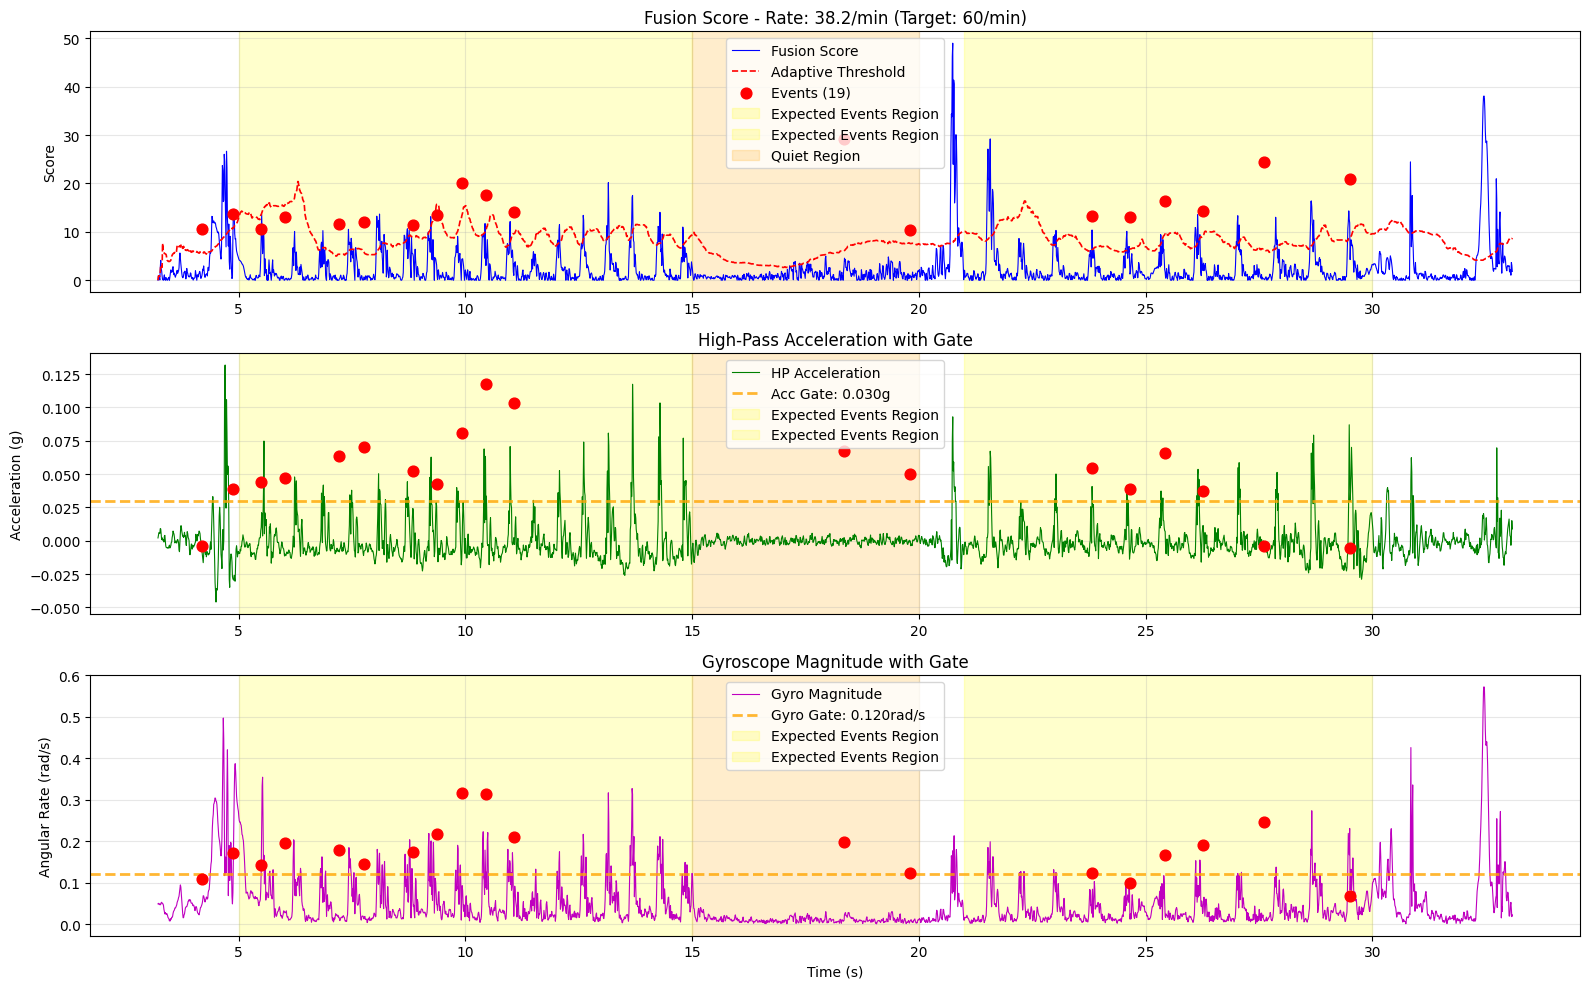

{'events': [{'peak_idx': np.int64(417),
   'peak_time': np.float64(4.199623346328735),
   'start_idx': 415,
   'end_idx': 428,
   'duration_samples': 14,
   'duration_ms': np.float64(140.99454879760742),
   'peak_score': np.float64(10.51339557395462),
   'peak_acc': np.float64(-0.004136389409751357),
   'peak_gyro': np.float64(0.10931153229358227),
   'threshold_at_peak': np.float64(5.9526009867300855)},
  {'peak_idx': np.int64(485),
   'peak_time': np.float64(4.884454011917114),
   'start_idx': 477,
   'end_idx': 491,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
   'peak_score': np.float64(13.672195068746408),
   'peak_acc': np.float64(0.03852936604977772),
   'peak_gyro': np.float64(0.1708466723763808),
   'threshold_at_peak': np.float64(6.719953376083591)},
  {'peak_idx': np.int64(546),
   'peak_time': np.float64(5.4987874031066895),
   'start_idx': 538,
   'end_idx': 552,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
  

In [19]:
test_parameters(acc_gate=0.030, gyro_gate=0.120, threshold_k=5.5, refractory_ms=150, adaptive_window=2.0)

=== TESTING PARAMETERS ===
ACC_GATE = 0.025g
GYRO_GATE = 0.100rad/s
THRESHOLD_K = 5.5
REFRACTORY_MS = 200ms
ADAPTIVE_WINDOW = 3.0s
----------------------------------------
RESULTS:
  Events detected: 18
  Detection rate: 36.2 events/min
  Target rate: 60 events/min
  Rate error: 23.8 events/min
  Median duration: 115.8 ms
  Duration range: 20.1 - 161.1 ms
  Median peak acc: 0.045 g
  Median peak gyro: 0.176 rad/s
  Median IEI: 0.786 s (76.4/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 1

FIRST 3 EVENTS:
  Event 1: t=4.88s, score=11.5, acc=0.039g, gyro=0.171rad/s, dur=141.0ms
  Event 2: t=5.54s, score=12.5, acc=0.018g, gyro=0.159rad/s, dur=161.1ms
  Event 3: t=6.01s, score=14.6, acc=0.047g, gyro=0.196rad/s, dur=151.1ms


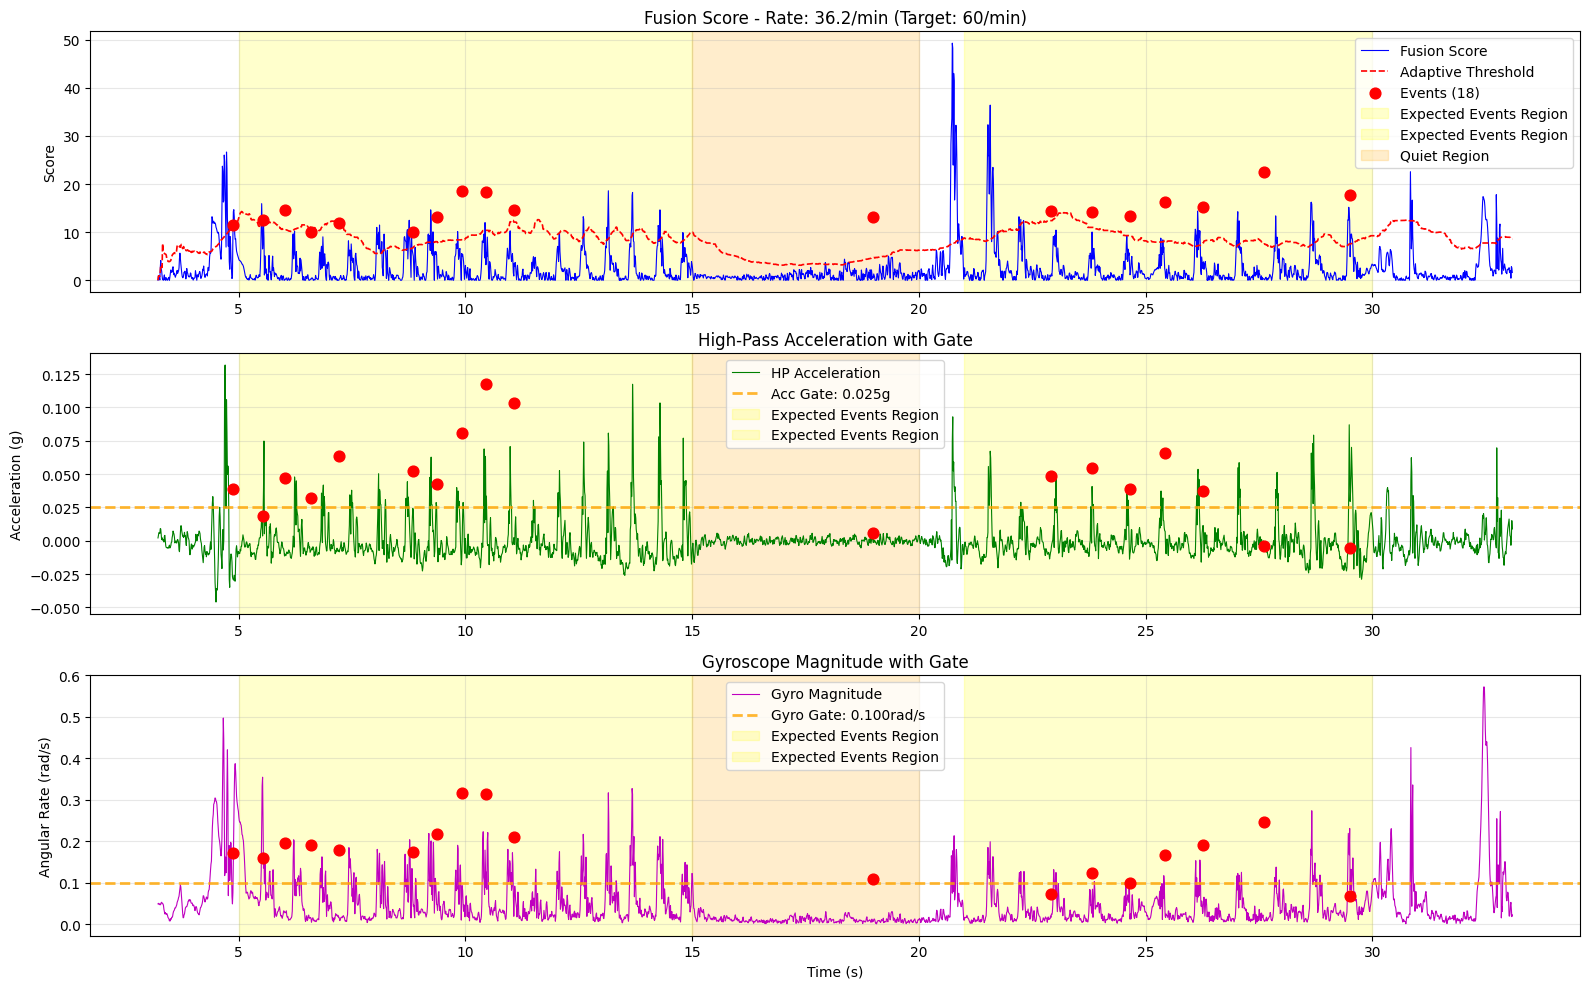

{'events': [{'peak_idx': np.int64(485),
   'peak_time': np.float64(4.884454011917114),
   'start_idx': 477,
   'end_idx': 490,
   'duration_samples': 14,
   'duration_ms': np.float64(140.99454879760742),
   'peak_score': np.float64(11.475943349182126),
   'peak_acc': np.float64(0.03852936604977772),
   'peak_gyro': np.float64(0.1708466723763808),
   'threshold_at_peak': np.float64(5.572110312382216)},
  {'peak_idx': np.int64(550),
   'peak_time': np.float64(5.539071559906006),
   'start_idx': 538,
   'end_idx': 553,
   'duration_samples': 16,
   'duration_ms': np.float64(161.13662719726562),
   'peak_score': np.float64(12.466005790289666),
   'peak_acc': np.float64(0.018284122083129215),
   'peak_gyro': np.float64(0.15908292182270622),
   'threshold_at_peak': np.float64(6.481052191832172)},
  {'peak_idx': np.int64(597),
   'peak_time': np.float64(6.012410402297974),
   'start_idx': 590,
   'end_idx': 604,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
   '

In [22]:
test_parameters(acc_gate=0.025, gyro_gate=0.100, threshold_k=5.5,
                  refractory_ms=200, adaptive_window=3.0)

=== TESTING PARAMETERS ===
ACC_GATE = 0.020g
GYRO_GATE = 0.080rad/s
THRESHOLD_K = 6.0
REFRACTORY_MS = 180ms
ADAPTIVE_WINDOW = 4.0s
----------------------------------------
RESULTS:
  Events detected: 20
  Detection rate: 40.2 events/min
  Target rate: 60 events/min
  Rate error: 19.8 events/min
  Median duration: 105.7 ms
  Duration range: 20.1 - 171.2 ms
  Median peak acc: 0.048 g
  Median peak gyro: 0.184 rad/s
  Median IEI: 0.786 s (76.4/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 2

FIRST 3 EVENTS:
  Event 1: t=1.51s, score=26.6, acc=0.106g, gyro=0.213rad/s, dur=171.2ms
  Event 2: t=2.29s, score=15.9, acc=0.021g, gyro=0.227rad/s, dur=70.5ms
  Event 3: t=5.50s, score=8.1, acc=0.044g, gyro=0.144rad/s, dur=90.6ms


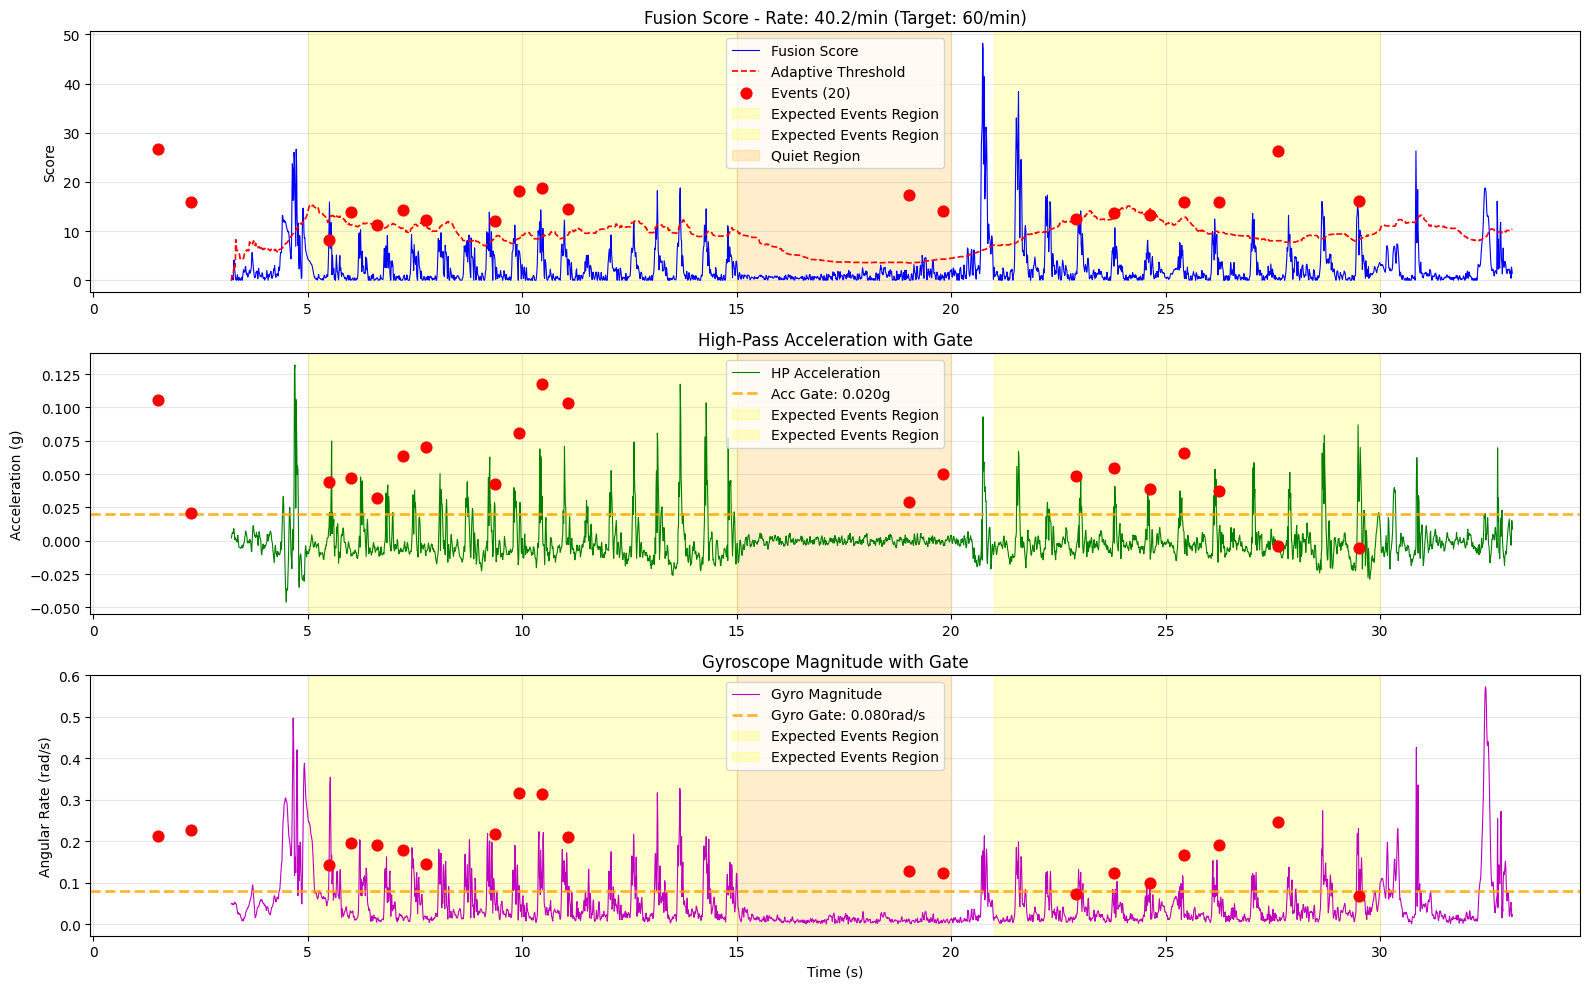

{'events': [{'peak_idx': np.int64(150),
   'peak_time': np.float64(1.5106558799743652),
   'start_idx': 139,
   'end_idx': 155,
   'duration_samples': 17,
   'duration_ms': np.float64(171.20766639709473),
   'peak_score': np.float64(26.6488108405925),
   'peak_acc': np.float64(0.10574759207057927),
   'peak_gyro': np.float64(0.21269143514637978),
   'threshold_at_peak': np.float64(10.282761804286302)},
  {'peak_idx': np.int64(227),
   'peak_time': np.float64(2.286125898361206),
   'start_idx': 226,
   'end_idx': 232,
   'duration_samples': 7,
   'duration_ms': np.float64(70.49727439880371),
   'peak_score': np.float64(15.921074054564803),
   'peak_acc': np.float64(0.021071562226224888),
   'peak_gyro': np.float64(0.22731514394808092),
   'threshold_at_peak': np.float64(12.397142019538519)},
  {'peak_idx': np.int64(546),
   'peak_time': np.float64(5.4987874031066895),
   'start_idx': 538,
   'end_idx': 546,
   'duration_samples': 9,
   'duration_ms': np.float64(90.63935279846191),
   'p

In [23]:
test_parameters(acc_gate=0.020, gyro_gate=0.080, threshold_k=6.0,
                  refractory_ms=180, adaptive_window=4.0)

=== TESTING PARAMETERS ===
ACC_GATE = 0.018g
GYRO_GATE = 0.075rad/s
THRESHOLD_K = 7.6
REFRACTORY_MS = 175ms
ADAPTIVE_WINDOW = 4.5s
----------------------------------------
RESULTS:
  Events detected: 15
  Detection rate: 30.1 events/min
  Target rate: 60 events/min
  Rate error: 29.9 events/min
  Median duration: 80.6 ms
  Duration range: 30.2 - 171.2 ms
  Median peak acc: 0.055 g
  Median peak gyro: 0.190 rad/s
  Median IEI: 0.831 s (72.2/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 2

FIRST 3 EVENTS:
  Event 1: t=1.51s, score=26.6, acc=0.106g, gyro=0.213rad/s, dur=171.2ms
  Event 2: t=2.29s, score=15.9, acc=0.021g, gyro=0.227rad/s, dur=30.2ms
  Event 3: t=6.01s, score=13.3, acc=0.047g, gyro=0.196rad/s, dur=50.4ms


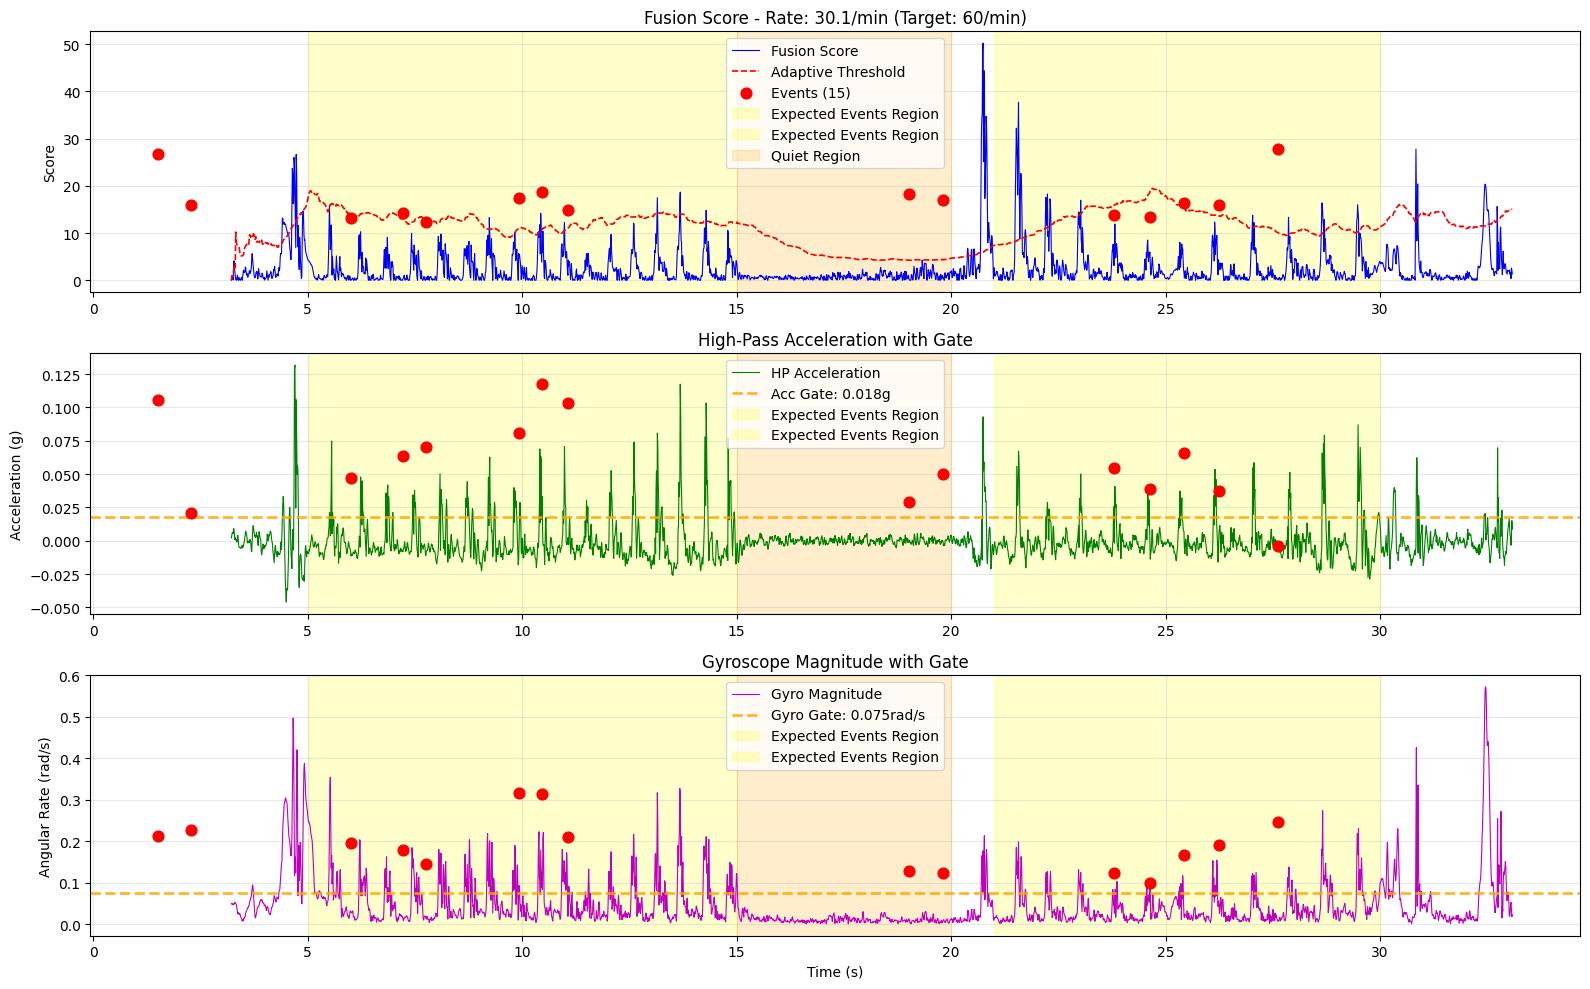

{'events': [{'peak_idx': np.int64(150),
   'peak_time': np.float64(1.5106558799743652),
   'start_idx': 139,
   'end_idx': 155,
   'duration_samples': 17,
   'duration_ms': np.float64(171.20766639709473),
   'peak_score': np.float64(26.6488108405925),
   'peak_acc': np.float64(0.10574759207057927),
   'peak_gyro': np.float64(0.21269143514637978),
   'threshold_at_peak': np.float64(12.61892628138607)},
  {'peak_idx': np.int64(227),
   'peak_time': np.float64(2.286125898361206),
   'start_idx': 226,
   'end_idx': 228,
   'duration_samples': 3,
   'duration_ms': np.float64(30.213117599487305),
   'peak_score': np.float64(15.921074054564803),
   'peak_acc': np.float64(0.021071562226224888),
   'peak_gyro': np.float64(0.22731514394808092),
   'threshold_at_peak': np.float64(15.273495244148897)},
  {'peak_idx': np.int64(597),
   'peak_time': np.float64(6.012410402297974),
   'start_idx': 594,
   'end_idx': 598,
   'duration_samples': 5,
   'duration_ms': np.float64(50.35519599914551),
   'pe

In [24]:
test_parameters(acc_gate=0.018, gyro_gate=0.075, threshold_k=7.6,
                  refractory_ms=175, adaptive_window=4.5)

=== TESTING PARAMETERS ===
ACC_GATE = 0.018g
GYRO_GATE = 0.075rad/s
THRESHOLD_K = 4.5
REFRACTORY_MS = 175ms
ADAPTIVE_WINDOW = 3.5s
----------------------------------------
RESULTS:
  Events detected: 21
  Detection rate: 42.2 events/min
  Target rate: 60 events/min
  Rate error: 17.8 events/min
  Median duration: 130.9 ms
  Duration range: 20.1 - 191.3 ms
  Median peak acc: 0.039 g
  Median peak gyro: 0.178 rad/s
  Median IEI: 0.796 s (75.4/min)
  Events in 10-15s region: 2
  Events in 15-20s region: 2

FIRST 3 EVENTS:
  Event 1: t=2.29s, score=15.9, acc=0.021g, gyro=0.227rad/s, dur=80.6ms
  Event 2: t=4.88s, score=10.4, acc=0.039g, gyro=0.171rad/s, dur=130.9ms
  Event 3: t=5.54s, score=10.4, acc=0.018g, gyro=0.159rad/s, dur=151.1ms


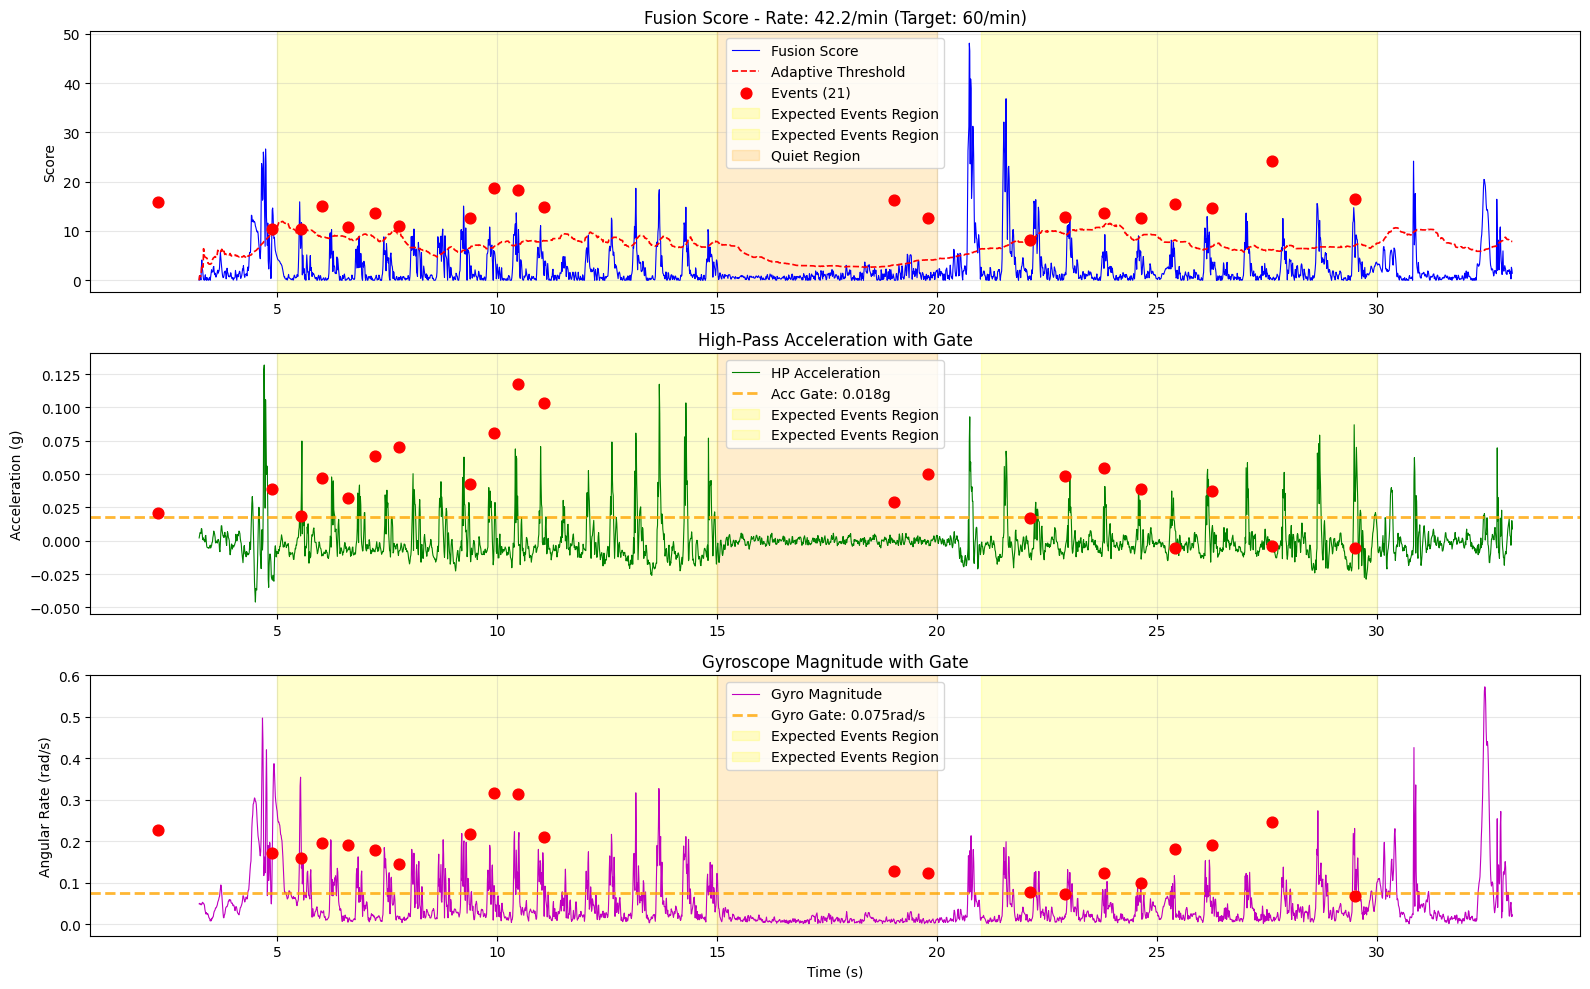

{'events': [{'peak_idx': np.int64(227),
   'peak_time': np.float64(2.286125898361206),
   'start_idx': 225,
   'end_idx': 232,
   'duration_samples': 8,
   'duration_ms': np.float64(80.56831359863281),
   'peak_score': np.float64(15.921074054564803),
   'peak_acc': np.float64(0.021071562226224888),
   'peak_gyro': np.float64(0.22731514394808092),
   'threshold_at_peak': np.float64(9.700560871466289)},
  {'peak_idx': np.int64(485),
   'peak_time': np.float64(4.884454011917114),
   'start_idx': 478,
   'end_idx': 490,
   'duration_samples': 13,
   'duration_ms': np.float64(130.92350959777832),
   'peak_score': np.float64(10.400967503692643),
   'peak_acc': np.float64(0.03852936604977772),
   'peak_gyro': np.float64(0.1708466723763808),
   'threshold_at_peak': np.float64(6.6503962881294285)},
  {'peak_idx': np.int64(550),
   'peak_time': np.float64(5.539071559906006),
   'start_idx': 538,
   'end_idx': 552,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
   'p

In [25]:
test_parameters(acc_gate=0.018, gyro_gate=0.075, threshold_k=4.5,
                  refractory_ms=175, adaptive_window=3.5)

=== TESTING PARAMETERS ===
ACC_GATE = 0.018g
GYRO_GATE = 0.075rad/s
THRESHOLD_K = 6.5
REFRACTORY_MS = 275ms
ADAPTIVE_WINDOW = 1.5s
----------------------------------------
RESULTS:
  Events detected: 21
  Detection rate: 42.2 events/min
  Target rate: 60 events/min
  Rate error: 17.8 events/min
  Median duration: 110.8 ms
  Duration range: 20.1 - 171.2 ms
  Median peak acc: 0.047 g
  Median peak gyro: 0.167 rad/s
  Median IEI: 0.730 s (82.2/min)
  Events in 10-15s region: 3
  Events in 15-20s region: 1

FIRST 3 EVENTS:
  Event 1: t=1.51s, score=26.2, acc=0.106g, gyro=0.213rad/s, dur=171.2ms
  Event 2: t=3.64s, score=8.9, acc=0.037g, gyro=0.052rad/s, dur=60.4ms
  Event 3: t=4.20s, score=14.0, acc=-0.004g, gyro=0.109rad/s, dur=151.1ms


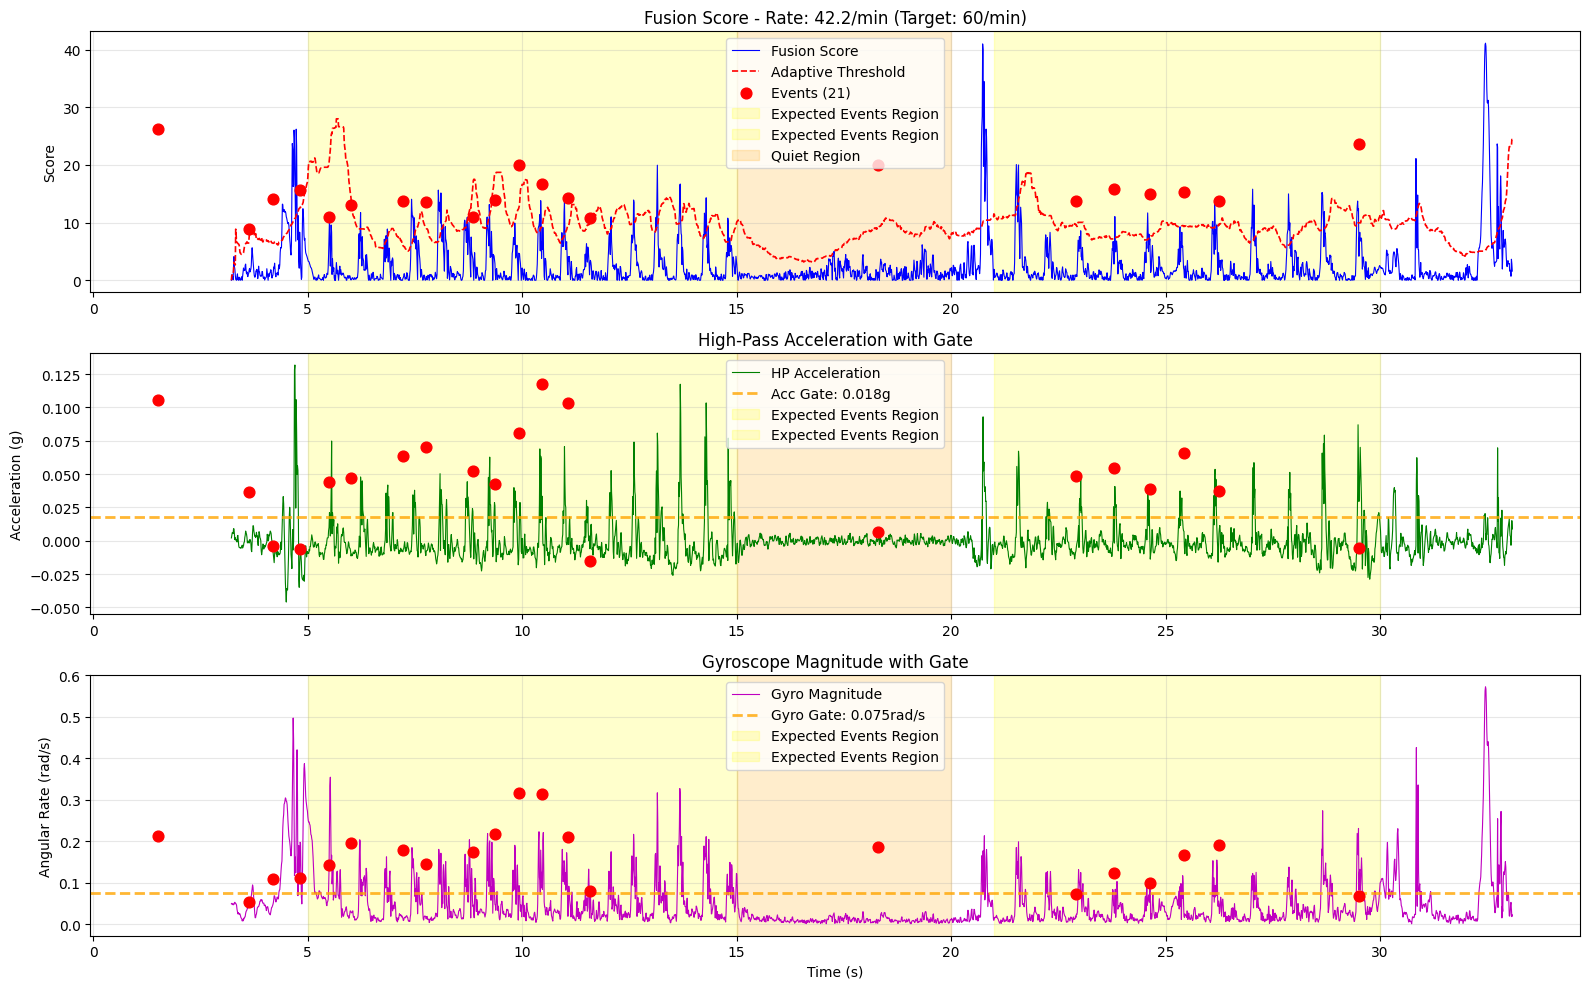

{'events': [{'peak_idx': np.int64(150),
   'peak_time': np.float64(1.5106558799743652),
   'start_idx': 139,
   'end_idx': 155,
   'duration_samples': 17,
   'duration_ms': np.float64(171.20766639709473),
   'peak_score': np.float64(26.18886390188846),
   'peak_acc': np.float64(0.10574759207057927),
   'peak_gyro': np.float64(0.21269143514637978),
   'threshold_at_peak': np.float64(11.213874571638133)},
  {'peak_idx': np.int64(361),
   'peak_time': np.float64(3.6356451511383057),
   'start_idx': 357,
   'end_idx': 362,
   'duration_samples': 6,
   'duration_ms': np.float64(60.42623519897461),
   'peak_score': np.float64(8.884912081802877),
   'peak_acc': np.float64(0.03683550526526074),
   'peak_gyro': np.float64(0.05243386275233254),
   'threshold_at_peak': np.float64(7.487752066580575)},
  {'peak_idx': np.int64(417),
   'peak_time': np.float64(4.199623346328735),
   'start_idx': 415,
   'end_idx': 429,
   'duration_samples': 15,
   'duration_ms': np.float64(151.06558799743652),
   'p

In [31]:
test_parameters(acc_gate=0.018, gyro_gate=0.075, threshold_k=6.5,
                  refractory_ms=275, adaptive_window=1.5)